In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
from glob import glob
from tqdm.auto import tqdm
import h5py
import os.path
from scipy import stats

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu

# Functions

In [2]:
def jaccard_oneaxis_xy(x, y):
    """Columns must be sites, rows species."""
    return (x & y).sum(axis=0) / (x | y).sum(axis=0)

In [3]:
import random 

def find_presences(input_matrix):
    num_rows, num_cols = input_matrix.shape
    hp = []
    iters = num_rows if num_cols >= num_rows else num_cols
    input_matrix_b = input_matrix if num_cols >= num_rows else np.transpose(input_matrix)
    for r in range(iters):
        hp.append(list(np.where(input_matrix_b[r] == 1)[0]))
    return hp

def curve_ball(input_matrix, r_hp, num_iterations=-1):
    """doi: 10.1038/ncomms5114"""
    num_rows, num_cols = input_matrix.shape
    l = range(len(r_hp))
    num_iters = 5*min(num_rows, num_cols) if num_iterations == -1 else num_iterations
    for rep in range(num_iters):
        AB = random.sample(l, 2)
        a = AB[0]
        b = AB[1]
        ab = set(r_hp[a])&set(r_hp[b]) # common elements
        l_ab=len(ab)
        l_a=len(r_hp[a])
        l_b=len(r_hp[b])
        if l_ab not in [l_a,l_b]:
            tot=list(set(r_hp[a]+r_hp[b])-ab)
            ab=list(ab)
            random.shuffle(tot)
            L=l_a-l_ab
            r_hp[a] = ab+tot[:L]
            r_hp[b] = ab+tot[L:]
    out_mat = np.zeros(input_matrix.shape, dtype=np.float32) if num_cols >= num_rows else np.zeros(input_matrix.T.shape, dtype='int8')
    for r in range(min(num_rows, num_cols)):
        out_mat[r, r_hp[r]] = 1
    result = out_mat if num_cols >= num_rows else out_mat.T
    return result

# Plot setttings

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import gaussian, fftconvolve
from matplotlib import ticker as mticker
import pygbrowse
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap as cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors
import matplotlib.patheffects as pe

kwargs = {'dpi':150}

coldict_cmap = {'None':'black',
                'scDamID':'lime',
                'sortChIC':'magenta',
                'Both':'white'
}
coldict = {'None':'black',
           'scDamID':'#00CC00',
           'sortChIC':'#D500DB',
           'Both':'white'
}
_cmap =  cmap.from_list('cbar',list(coldict_cmap.values()))

violinprops = {'linewidth':1,
               'edgecolor':'k'
}
tick_kwargs = {'length':7}

# Global variables

In [5]:
CHROMS = [str(i) for i in list(range(1,23)) + ["X"]]
CHROMSIZES = '/Users/prullens/metadata/hg19_chrom_sizes.tsv'
chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(sum).to_dict()

BINSIZE = 100000
SMOOTH_STDDEV = 150000

BLACKLIST = '/Users/prullens/metadata/hg19.blacklist.bed'

DAMEXPECTED = '/Users/prullens/metadata/hg19_mappability_binsize_%i.hdf5'
CHICEXPECTED = '/Users/prullens/Documents/projects/DamnChIC/experiments/KIN6668_mnase/hdf5/KIN6668_mnase.index46.BC_ChIC_088.top_n_16.chic.event_counts.binsize_%i.hdf5'

W = gaussian(ceil(SMOOTH_STDDEV / BINSIZE * 6 / 2) * 2 + 1, SMOOTH_STDDEV / BINSIZE)
W /= W.sum()

IDX6062 = [10,19,20,21]
IDX8433 = [2,3,4,5,6]

DAMFNFMT_DOWN = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.top_n_1.event_counts.DOWNSAMPLED.binsize_%i.hdf5'
DAMFNFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.top_n_1.event_counts.binsize_%i.hdf5'

CHICFNFMT_DOWN = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.top_n_1.chic.AT_noTC.event_counts.DOWNSAMPLED.binsize_%i.hdf5'
CHICFNFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.top_n_1.chic.AT_noTC.event_counts.binsize_%i.hdf5'

OUTDIR = '/Users/prullens/Documents/manuscripts/Kefalopoulou_2021/figure_kbm7_memory/'

# Data

_Metadata_

In [6]:
columns = ['indexnr',
           'barcodenr',
           'cellcycle_phase',
           '_column',
           '_row',
           '_well',
           'condition',
           'induction',
           'limsid',
           'hoechst'
]

len(columns)

10

In [7]:
anno6062 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN6062/KIN6062_anno_hoechst.tsv', sep='\t')
anno6062.index = anno6062['limsid'] + '.index' +  anno6062['indexnr'].astype(str).str.zfill(2) + '.' + anno6062['barcodenr'].astype(str).str.zfill(3)
anno6062['induction'] = 'Shield_15h'
anno6062 = anno6062.loc[anno6062['indexnr'].isin(IDX6062),columns]

anno6062.shape

(1536, 10)

In [8]:
anno8433 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8433_memo/KIN8433_anno_memo.tsv', sep='\t')
anno8433.index = ['KIN8433_memo.index{:02d}.{:03d}'.format(i,bc) for i,bc in anno8433[['indexnr','barcodenr']].values]
anno8433['hoechst'] = np.nan
anno8433 = anno8433.loc[anno8433['indexnr'].isin(IDX8433),columns]
anno8433['limsid'] = 'KIN8433_memo'

anno8433.shape

(1920, 10)

In [9]:
anno = pd.concat([anno6062,anno8433])

anno.shape

(3456, 10)

_LAD calls_

In [10]:
lads = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8433_memo/PR20230303.damchic_kbm7_consensus_lads_kin8433_memo.bed', sep='\t', header=None)
lads_dict = {c: np.zeros((chromsizes[c]//BINSIZE)+1, dtype=bool) for c in CHROMS}
for c,s,e in lads.values:
    lads_dict[c][s//BINSIZE:e//BINSIZE] = True
    
lads1d = np.hstack(list(lads_dict.values()))
ladsize = np.diff(lads[[1,2]]).reshape(-1,)

lads[3] = np.diff(lads[[1,2]], axis=1)

_nucleotide content_

In [11]:
fn = '/Users/prullens/metadata/Homo_sapiens.GRCh37.dna.primary_assembly.with_ERCC.nucleotide_content_ACGTN.binsize_100000.hdf5'

with h5py.File(fn, 'r') as f:
    nucleotide_content = {c: f[c][:] for c in CHROMS}

In [12]:
at_content = {c: nucleotide_content[c][[0,3]].sum(0) / nucleotide_content[c].sum(0) for c in CHROMS}
gc_content = {c: nucleotide_content[c][[1,2]].sum(0) / nucleotide_content[c].sum(0) for c in CHROMS}

In [13]:
lads['at_content'] = [at_content[c][s//BINSIZE:e//BINSIZE].mean() for c,s,e in lads[[0,1,2]].values]

_GTF_

In [14]:
gtf = pd.read_csv('/Users/prullens/metadata/Homo_sapiens.GRCh37.dna.gencode.v26lift37.basic.with_ERCC.gff.tsv.gz', sep='\t', index_col='gene_id')

In [15]:
gene_density = {c: np.zeros((chromsizes[c] // BINSIZE)+1) for c in CHROMS}
for c,s,e in gtf.loc[gtf['Chromosome'].isin(CHROMS),['Chromosome','Start','End']].values:
    s //= BINSIZE
    e //= BINSIZE
    gene_density[c][s:e+1] += 1
    
lads['gene_density'] = [gene_density[c][s//BINSIZE:e//BINSIZE].mean() for c,s,e in lads[[0,1,2]].values]

_DamID_

In [16]:
hdf5_list = [DAMFNFMT_DOWN %(limsid,limsid,i,bc,BINSIZE) 
             if os.path.isfile(DAMFNFMT_DOWN %(limsid,limsid,i,bc,BINSIZE)) 
             else DAMFNFMT %(limsid,limsid,i,bc,BINSIZE) 
             for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values
]

counts_dam, depths = scct.load_counts(hdf5_list, BINSIZE, CHROMSIZES, chroms=CHROMS)

anno['dam_counts'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

  0%|          | 0/3456 [00:00<?, ?it/s]

In [17]:
oe_dam, depths = scct.compute_oe(counts_dam, BINSIZE, CHROMSIZES, 2000, expected=DAMEXPECTED %BINSIZE, 
                                 blacklist=BLACKLIST, chroms=CHROMS, disable_tqdm=True)


len(oe_dam)

2007

In [18]:
oe_dam_smooth = scct.gaussian_smoothing(oe_dam, BINSIZE, SMOOTH_STDDEV, disable_tqdm=False)

  0%|          | 0/2007 [00:00<?, ?it/s]

In [19]:
signoise = scct.signaltonoise(oe_dam)

anno['dam_signaltonoise'] = [signoise[bc] if bc in signoise else 0 for bc in anno.index]

_ChIC_

In [20]:
hdf5_list = [CHICFNFMT_DOWN %(limsid,limsid,i,bc,BINSIZE) 
             if os.path.isfile(CHICFNFMT_DOWN %(limsid,limsid,i,bc,BINSIZE)) 
             else CHICFNFMT %(limsid,limsid,i,bc,BINSIZE) 
             for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values
]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

counts_chic, depths = scct.load_counts(hdf5_list, BINSIZE, CHROMSIZES, chroms=CHROMS)

anno['chic_counts'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

  0%|          | 0/3451 [00:00<?, ?it/s]

In [21]:
oe_chic, depths = scct.compute_oe(counts_chic, BINSIZE, CHROMSIZES, 1000, expected=CHICEXPECTED %BINSIZE, 
                                  blacklist=BLACKLIST, chroms=CHROMS, disable_tqdm=True)

len(oe_chic)

2822

In [22]:
oe_chic_smooth = scct.gaussian_smoothing(oe_chic, BINSIZE, SMOOTH_STDDEV, disable_tqdm=False)

  0%|          | 0/2822 [00:00<?, ?it/s]

In [23]:
signoise = scct.signaltonoise(oe_chic)

anno['chic_signaltonoise'] = [signoise[bc] if bc in signoise else 0 for bc in anno.index]

# Plotting

In [24]:
anno_sub = pd.DataFrame(anno[(anno.index.isin(list(oe_dam))) & 
                             (anno.index.isin(list(oe_chic))) & 
                             (anno['dam_signaltonoise'] < np.percentile(anno['dam_signaltonoise'], 99)) & 
                             (anno['chic_signaltonoise'] < np.percentile(anno['chic_signaltonoise'], 98))
])
anno_sub.shape

(1835, 14)

In [25]:
gb = anno_sub.groupby(['condition','induction','cellcycle_phase'])

gb.size().to_frame('Cells')

Cells
condition    induction  cellcycle_phase       
DamChIC      Shield_15h G1                 395
                        S/G2               470
synchronized Shield_13h G1                 246
                        G2                 231
             no_Shield  G1                 226
                        G2                 267

In [26]:
bc_dict = gb.groups

list(bc_dict)

[('DamChIC', 'Shield_15h', 'G1'),
 ('DamChIC', 'Shield_15h', 'S/G2'),
 ('synchronized', 'Shield_13h', 'G1'),
 ('synchronized', 'Shield_13h', 'G2'),
 ('synchronized', 'no_Shield', 'G1'),
 ('synchronized', 'no_Shield', 'G2')]

In [27]:
dam_idx = np.hstack(list(oe_dam[list(oe_dam)[0]].values())) > .101
chic_idx = np.hstack(list(oe_chic[list(oe_chic)[0]].values())) > .101

incl_idx = dam_idx & chic_idx

np.sum(dam_idx), np.sum(chic_idx), np.sum(incl_idx)

(27787, 25446, 25446)

In [28]:
chroms1d = np.hstack([np.repeat(c,(chromsizes[c]//BINSIZE)+1) for c in CHROMS])

chroms1d.size

30376

_______

# LAD inheritance upon mitosis

In [29]:
edges = np.diff(lads1d.astype(np.int8), prepend=0, append=0)
rising = np.where(edges == 1)[0]
falling = np.where(edges == -1)[0]

In [30]:
Zgroups_lads = dict()
for g in list(bc_dict)[2:]:
    X = np.array([np.hstack(list(oe_dam_smooth[bc].values())) > 1 for bc in bc_dict[g]], dtype=int)
    y = np.array([np.hstack(list(oe_chic_smooth[bc].values())) > 1 for bc in bc_dict[g]], dtype=int)

    Z = X + y
    Z[y == 1] += 1
    
    event_counts = np.zeros((4,len(bc_dict[g]),lads.shape[0]))
    for event in range(4):
        cum = np.insert(np.cumsum(Z == event, axis=1), 0, 0, axis=1)
        event_counts[event] = cum[:,falling] - cum[:,rising]
        
    Zgroups_lads[g] = np.argmax(event_counts, axis=0)
    print(g)

('synchronized', 'Shield_13h', 'G1')
('synchronized', 'Shield_13h', 'G2')
('synchronized', 'no_Shield', 'G1')
('synchronized', 'no_Shield', 'G2')


In [31]:
Xgroups_lads = dict()
ygroups_lads = dict()
for g in Zgroups_lads:
    Xgroups_lads[g] = ((Zgroups_lads[g] == 1) | (Zgroups_lads[g] == 3)).astype(int)
    ygroups_lads[g] = (Zgroups_lads[g] >= 2).astype(int)

____

In [32]:
groups = [('synchronized', 'Shield_13h', 'G2'), 
          ('synchronized', 'Shield_13h', 'G1')
]

groups

[('synchronized', 'Shield_13h', 'G2'), ('synchronized', 'Shield_13h', 'G1')]

In [87]:
niter = 100

np.random.seed(50)

lad_idx = lads[0] != '8' #chr8 is diploid in kbm7 cells

j_Z_dict = dict()
jrand_Z_dict = dict()
for g in groups:
    size = Xgroups_lads[g].shape[0]
    randint = np.random.choice(np.arange(size), size, False)

    X = Xgroups_lads[g][:,lad_idx]
    y = ygroups_lads[g][:,lad_idx]
    yrand = y[randint]

    j = jaccard_oneaxis_xy(X, y)
    jrand = jaccard_oneaxis_xy(X, yrand)

    j_perm = np.zeros((niter,X.shape[1]))
    jrand_perm = np.zeros((niter,X.shape[1]))
    for i in tqdm(range(niter)):
        hp = find_presences(y)
        y_perm = curve_ball(y, hp, num_iterations=-1).astype(int)
        j_perm[i] = jaccard_oneaxis_xy(X, y_perm)

        hp = find_presences(yrand)
        yrand_perm = curve_ball(yrand, hp, num_iterations=-1).astype(int)
        jrand_perm[i] = jaccard_oneaxis_xy(X, yrand_perm)

    j_Z = (j - j_perm.mean(0)) / j_perm.std(0)
    jrand_Z = (jrand - jrand_perm.mean(0)) / jrand_perm.std(0)
    
    j_Z_dict[g[1:]] = j_Z
    jrand_Z_dict[g[1:]] = jrand_Z

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

____

Text(0, 0.5, 'Z(Jaccard similarity to G2 cell)')

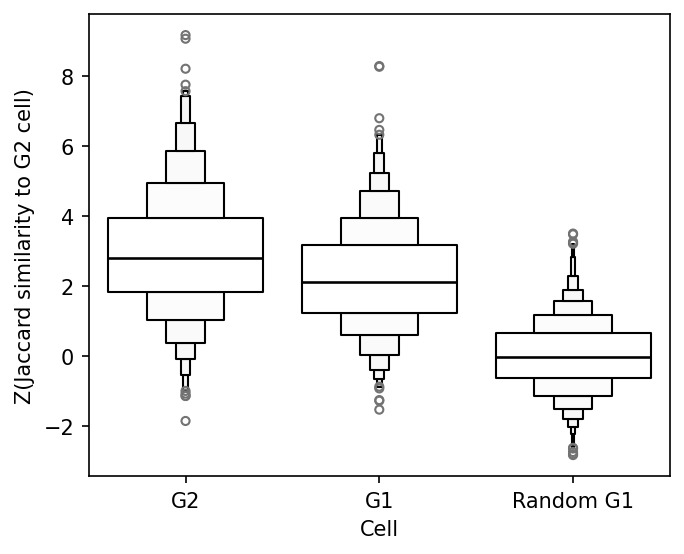

In [91]:
X = np.repeat(['G2','G1','Random G1','Random G1'], lad_idx.sum())
y = np.r_[j_Z_dict[('Shield_13h', 'G2')],
          j_Z_dict[('Shield_13h', 'G1')],
          jrand_Z_dict[('Shield_13h', 'G2')],
          jrand_Z_dict[('Shield_13h', 'G1')]]

f, ax = plt.subplots(figsize=(5,4), **kwargs)

sns.boxenplot(x=X, 
              y=y, 
              showfliers=True,
              color='white',
              linewidth=1,
              line_kws={'color':'k','alpha':1},
              flier_kws={'color':'k','s':15},
              box_kws={'edgecolor':'k'},
              order=['G2','G1','Random G1']
)

ax.set_xlabel('Cell')
ax.set_ylabel('Z(Jaccard similarity to G2 cell)')


#plt.savefig(OUTDIR + 'lad_inheritance_mitosis_zjaccard.pdf', bbox_inches='tight')

In [96]:
(
stats.ttest_ind(y[X == 'G2'], y[X == 'G1']),
stats.ttest_ind(y[X == 'G1'], y[X == 'Random G1'])
)

(Ttest_indResult(statistic=6.936444483139652, pvalue=7.093008147612124e-12),
 Ttest_indResult(statistic=34.29135658380532, pvalue=3.91068498592461e-192))

_____

Text(0, 0.5, 'Z(Jaccard similarity to Mother)')

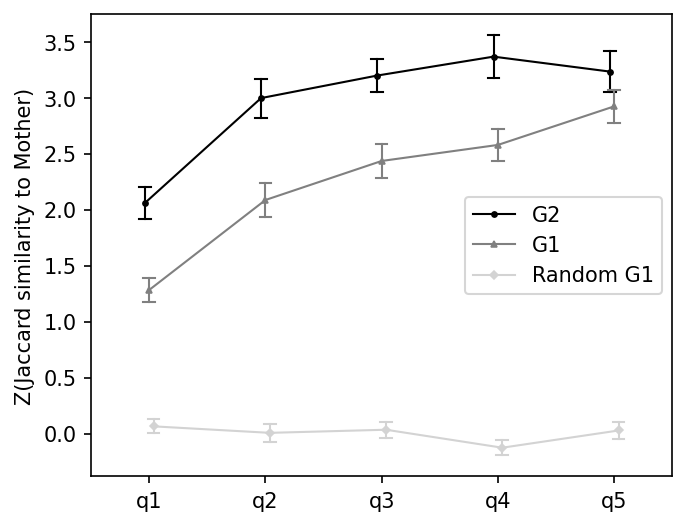

In [115]:
f, ax = plt.subplots(figsize=(5,4), **kwargs)


sns.pointplot(x=np.tile(quart[lad_idx], 4), 
              y=y,
              hue=X,
              order=np.unique(quart),
              dodge=True,
              estimator='mean',
              palette=['lightgray','gray','black'][::-1],
              errorbar='se',
              markers=['o','^','D'],
              capsize=.1,
              lw=1
            
)

ax.set_ylabel('Z(Jaccard similarity to Mother)')

____

In [116]:
g = ('synchronized', 'Shield_13h', 'G1')

In [117]:
X = np.zeros(((lads[0] != '8').sum(),100))
for i,a in enumerate(Zgroups_lads[g][:,(lads[0] != '8')].T):
    l = 0
    for state in range(1,4):
        r = int((((a == state).sum() / (a > 0).sum()) * 100))
        X[i,l:l + r] = state

        l += r        
X = X[:,:-2]

X.shape

(516, 98)

Text(0.5, 0, 'Fraction of cells')

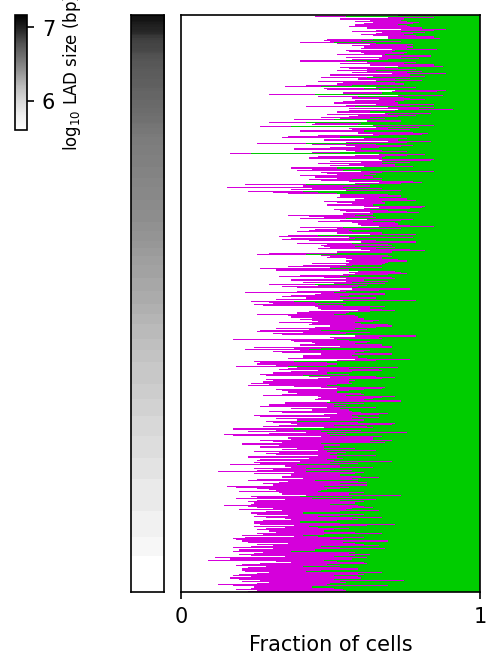

In [118]:
_argsort = np.argsort(ladsize[lads[0] != '8'])

f, ax = plt.subplots(1, 2, figsize=(3,5), gridspec_kw={'width_ratios':[.1,.9],'wspace':.1}, **kwargs)

pcf = ax[0].pcolorfast(np.log10(ladsize[lads[0] != '8'][_argsort].reshape(-1,1)), 
                       cmap='Greys'
)
ax[1].pcolorfast(X[_argsort][:,::-1], 
                 vmin=0, 
                 cmap=cmap.from_list('cbar',list(coldict.values()))
)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])

axins = inset_axes(ax[0],
                   width="20%",  
                   height="20%",
                   loc='lower left',
                   bbox_to_anchor=(-3.5, .8, 1.85, 1),
                   bbox_transform=ax[0].transAxes,
                   borderpad=0,
                   )
cbar = f.colorbar(pcf, ax=ax[0], cax=axins, orientation='vertical', pad=.06)
cbar.ax.set_ylabel('log$_{{{10}}}$ LAD size (bp)', fontsize=8, labelpad=3)

ax[1].set_xticks(ax[1].get_xlim())
ax[1].set_xticklabels([0,1])
ax[1].set_xlabel('Fraction of cells')

____

Text(0.5, 0, 'Fraction of cells')

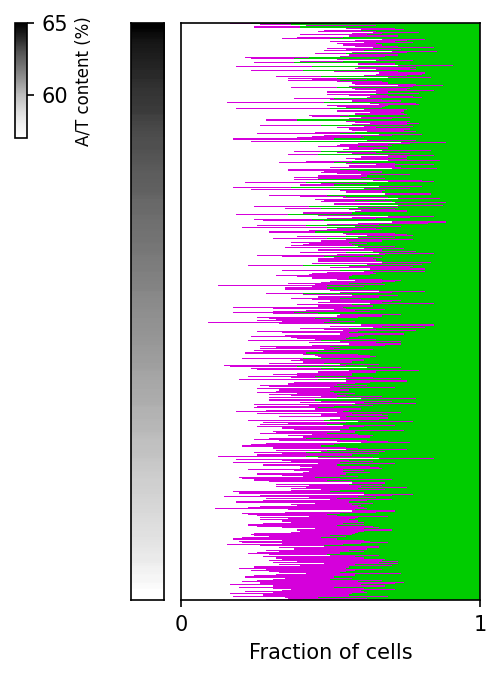

In [119]:
_argsort = np.argsort(lads.loc[lads[0] != '8','at_content'])

f, ax = plt.subplots(1, 2, figsize=(3,5), gridspec_kw={'width_ratios':[.1,.9],'wspace':.1}, **kwargs)

pcf = ax[0].pcolorfast(lads.loc[lads[0] != '8','at_content'].values[_argsort].reshape(-1,1) *100, 
                       cmap='Greys',
                       vmin=57, 
                       vmax=65
)
ax[1].pcolorfast(X[_argsort][:,::-1], 
                 vmin=0, 
                 cmap=cmap.from_list('cbar',list(coldict.values()))
)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])

axins = inset_axes(ax[0],
                   width="20%",  
                   height="20%",
                   loc='lower left',
                   bbox_to_anchor=(-3.5, .8, 1.85, 1),
                   bbox_transform=ax[0].transAxes,
                   borderpad=0,
                   )
cbar = f.colorbar(pcf, ax=ax[0], cax=axins, orientation='vertical', pad=.06)
cbar.ax.set_ylabel('A/T content (%)', fontsize=8, labelpad=3)

ax[1].set_xticks(ax[1].get_xlim())
ax[1].set_xticklabels([0,1])
ax[1].set_xlabel('Fraction of cells')

____

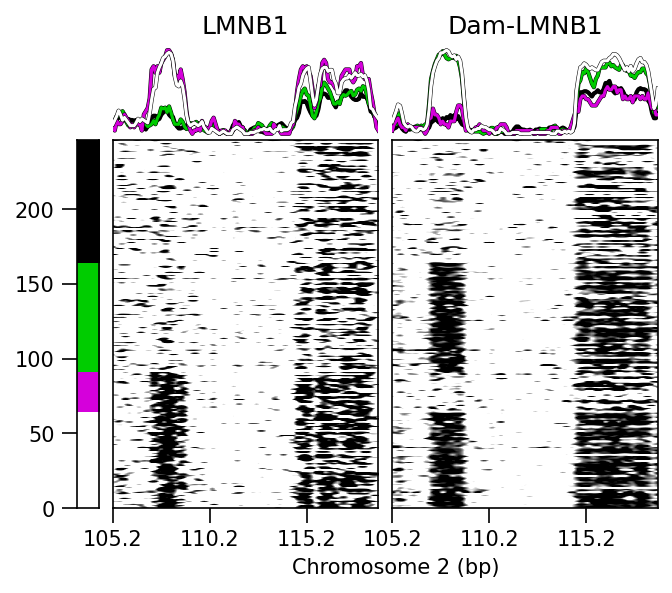

In [122]:
index = 53 #17, 53, 336, 386, 129, 221

chrom, s, e = lads.loc[index,:2]

ws = int((s-2e6)/BINSIZE)
we = int((e+10e6)/BINSIZE)

xaxis = np.arange(ws*BINSIZE,we*BINSIZE,BINSIZE) / 1e6

g = ('synchronized', 'Shield_13h', 'G1')
_bcs = bc_dict[g]
    
X = np.array([oe_dam_smooth[bc][chrom][ws:we] for bc in _bcs])
y = np.array([oe_chic_smooth[bc][chrom][ws:we] for bc in _bcs])

Z = Zgroups_lads[g][:,index]
_argsort = np.argsort(Z)[::-1]
yaxis = np.arange(_bcs.size)

f, ax = plt.subplots(2, 3, figsize=(5,4), 
                     gridspec_kw={'wspace':.075,
                                  'hspace':.01,
                                  'height_ratios':[.2,.8],
                                  'width_ratios':[.04,.475,.475]}, 
                     **kwargs)

ax[1,0].pcolorfast(Z[_argsort].reshape(-1,1), 
                   cmap=cmap.from_list('cbar',list(coldict.values()))
)

ax[1,1].imshow(np.log2(y)[_argsort], 
               vmin=-.75, 
               vmax=.75, 
               aspect='auto', 
               origin='lower',
               cmap='binary',
               interpolation='bilinear',
               extent=np.hstack([xaxis[[0,-1]],yaxis[[0,-1]]])
)
ax[1,2].imshow(np.log2(X)[_argsort], 
               vmin=-.75, 
               vmax=.75, 
               aspect='auto', 
               origin='lower',
               cmap='binary',
               interpolation='bilinear',
               extent=np.hstack([xaxis[[0,-1]],yaxis[[0,-1]]])
)

colors = list(coldict.values())
for i in range(4):
    idx = i == Zgroups_lads[g][:,index]
    ax[0,1].plot(xaxis, 
                 (y[idx] > 1).mean(0), 
                 color=colors[i], 
                 path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()]
    )
    ax[0,2].plot(xaxis, 
                 (X[idx] > 1).mean(0), 
                 color=colors[i], 
                 path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()]
    )
    
for i in range(ax.shape[1]):
    #ax[1,i].set_yticks(range(0,801,200))
    ax[1,i].tick_params(**tick_kwargs)
    
ax[1,1].set_yticks([])
ax[1,2].set_yticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,1].set_yticks([])
ax[0,2].set_yticks([])
ax[1,0].set_xticks([])

ax[0,1].set_title('LMNB1')
ax[0,2].set_title('Dam-LMNB1')
ax[0,1].margins(x=0)
ax[0,2].margins(x=0)
ax[0,0].remove()
f.text(0.55, 0.0, 'Chromosome %s (bp)' %chrom, ha='center')

ax[0,1].spines[['right','bottom','left','top']].set_visible(False)
ax[0,2].spines[['right','bottom','left','top']].set_visible(False)

ax[1,1].set_xticks(np.arange((ws*BINSIZE) / 1e6, (we*BINSIZE) / 1e6, 5))
ax[1,2].set_xticks(np.arange((ws*BINSIZE) / 1e6, (we*BINSIZE) / 1e6, 5))

____

0 ('DamChIC', 'Shield_15h', 'S/G2')
1 ('synchronized', 'Shield_13h', 'G2')


Text(0.5, 0, 'Chromosome 1 (Mb)')

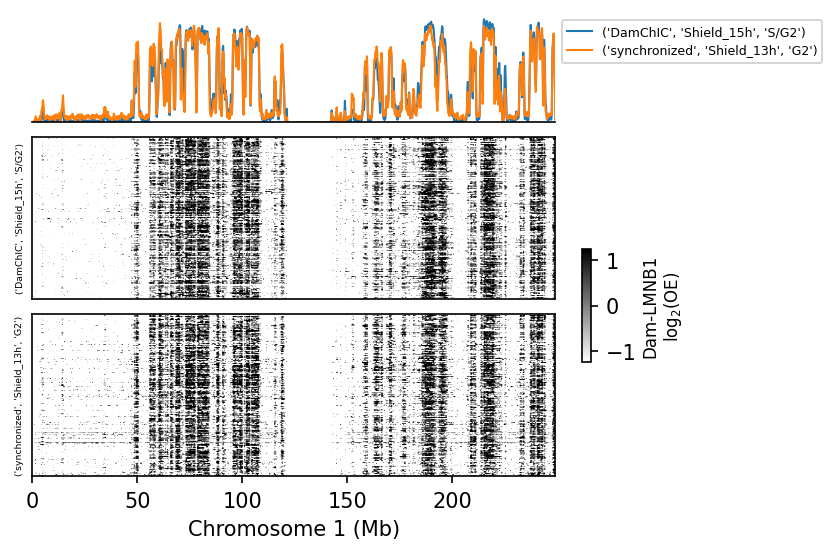

In [123]:
chrom = '1'

groups = [('DamChIC', 'Shield_15h', 'S/G2'),('synchronized', 'Shield_13h', 'G2')]

xaxis = np.arange(0,chromsizes[chrom],BINSIZE) / 1e6

f, ax = plt.subplots(nrows=3, 
                     ncols=1, 
                     figsize=(4.5,4), 
                     gridspec_kw={'height_ratios':[.2,.3,.3], 'hspace':.1},
                     **kwargs
)

ncells = 230
yaxis = np.arange(ncells)
for i,g in enumerate(groups):
    print(i,g)
    
    _bcs = anno_sub.loc[bc_dict[g],'dam_signaltonoise'].index
    X = np.log2([oe_dam_smooth[bc][chrom] for bc in _bcs])
    
    ax[0].plot(xaxis, 
               (X > 0).mean(0), 
               label=g, 
               lw=1
    )
    im = ax[i+1].imshow(X[:ncells], 
                   vmin=-1.25, 
                   vmax=1.25, 
                   cmap='binary', 
                   aspect='auto',
                   extent=np.hstack([xaxis[[0,-1]],yaxis[[0,-1]]])
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i+1].set_ylabel(g, fontsize=4.5)
    
ax[0].spines[['right','top','left']].set_visible(False)
ax[0].legend(prop={'size':6}, bbox_to_anchor=(1,1))
ax[0].set_ylim(0)
ax[0].margins(x=0)
ax[-1].set_yticks([])
    
axins = inset_axes(ax[2],
   width="1.25%",  # width = 5% of parent_bbox width
   height="70%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.05, .7, 1.5, 1),
   bbox_transform=ax[2].transAxes,
   borderpad=0,
   )
cbar = f.colorbar(im, ax=ax[2], cax=axins, pad=.06, ticks=[-1,0,1])
cbar.ax.set_ylabel('Dam-LMNB1\nlog$_{{{2}}}$(OE)', fontsize=8, labelpad=2)

ax[-1].set_xlabel('Chromosome %s (Mb)' %chrom)

____

# LAD inheritance and (epi)genomic features

Text(0, 0.5, 'Fraction of cells')

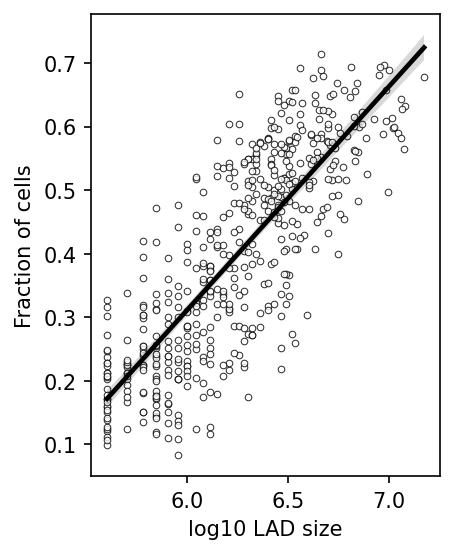

In [36]:
states = [1,2,3]

X = np.tile(np.log10(lads.loc[(lads[0] != '8'),3]), len(states))
states_sum = np.array([(Zgroups_lads[g][:,(lads[0] != '8')] == state).sum(0) for state in states])
total_sum = (Zgroups_lads[g][:,(lads[0] != '8')] > 0).sum(0)
y = np.hstack((states_sum / total_sum))
hue = np.repeat(['DamID','ChIC','Both'],(lads[0] != '8').sum())

idx = (hue == 'Both') & (X > .55)

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sns.regplot(x=X[idx], 
            y=y[idx],
            order=1,
            scatter_kws={'s':10,'color':'white','edgecolor':'k','lw':.5},
            line_kws={'color':'k'}
)

ax.set_xlabel('log10 LAD size')
ax.set_ylabel('Fraction of cells')

Text(0, 0.5, 'Fraction of cells')

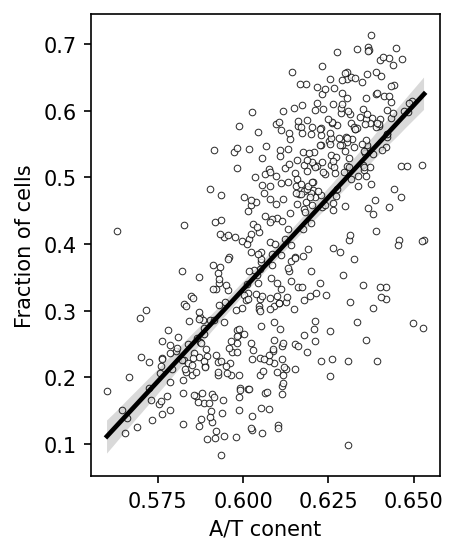

In [40]:
states = [1,2,3]

X = np.tile(lads.loc[(lads[0] != '8'),'at_content'], len(states)) 
states_sum = np.array([(Zgroups_lads[g][:,(lads[0] != '8')] == state).sum(0) for state in states])
total_sum = (Zgroups_lads[g][:,(lads[0] != '8')] > 0).sum(0)
y = np.hstack((states_sum / total_sum))
hue = np.repeat(['DamID','ChIC','Both'],(lads[0] != '8').sum())

idx = (hue == 'Both') & (X > .55)
xhat, yhat, yhat_sem = sccu.RNR(X[idx], y[idx], _RADIUS=.05, step=.01)

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sns.regplot(x=X[idx], 
            y=y[idx],
            order=1,
            scatter_kws={'s':10,'color':'white','edgecolor':'k','lw':.5},
            line_kws={'color':'k'}
)
# ax.plot(xhat, yhat, color='white', lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# ax.fill_between(xhat, yhat -yhat_sem, yhat + yhat_sem, color='white', alpha=.25, 
#                 path_effects=[pe.Stroke(linewidth=.5, foreground='k'), pe.Normal()])

#ax.legend(prop={'size':6})
ax.set_xlabel('A/T conent')
ax.set_ylabel('Fraction of cells')

Text(0, 0.5, 'Fraction of cells')

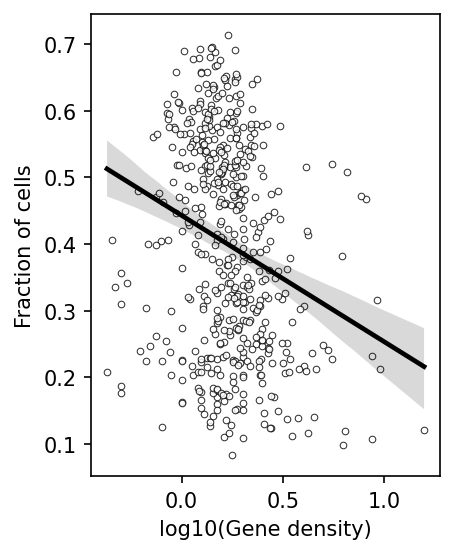

In [44]:
states = [1,2,3]

X = np.log10(np.tile(lads.loc[(lads[0] != '8'),'gene_density'], len(states)))
states_sum = np.array([(Zgroups_lads[g][:,(lads[0] != '8')] == state).sum(0) for state in states])
total_sum = (Zgroups_lads[g][:,(lads[0] != '8')] > 0).sum(0)
y = np.hstack((states_sum / total_sum))
hue = np.repeat(['DamID','ChIC','Both'],(lads[0] != '8').sum())

idx = (hue == 'Both') & (X > -.5)
xhat, yhat, yhat_sem = sccu.RNR(X[idx], y[idx], _RADIUS=.05, step=.01)

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sns.regplot(x=X[idx], 
            y=y[idx],
            order=1,
            scatter_kws={'s':10,'color':'white','edgecolor':'k','lw':.5},
            line_kws={'color':'k'}
)

ax.set_xlabel('log10(Gene density)')
ax.set_ylabel('Fraction of cells')

In [43]:
hdf5_list = glob('/Users/prullens/Documents/projects/DamnChIC/experiments/PR20241218.*_cf.binsize_100000.hdf5')

hptm_cf, _ = scct.load_counts(hdf5_list, BINSIZE, CHROMSIZES, dtype=np.float32, disable_tqdm=True)

labels = ['H3K4me3','H3K9me3','H3K27me3']
hptm_cf = {labels[i]: hptm_cf[k] for i,k in enumerate(hptm_cf)}

for antibody in hptm_cf:
    lads[antibody] = [hptm_cf[antibody][c][s//BINSIZE:e//BINSIZE].mean() for c,s,e in lads[[0,1,2]].values]

Text(0, 0.5, 'Fraction of cells')

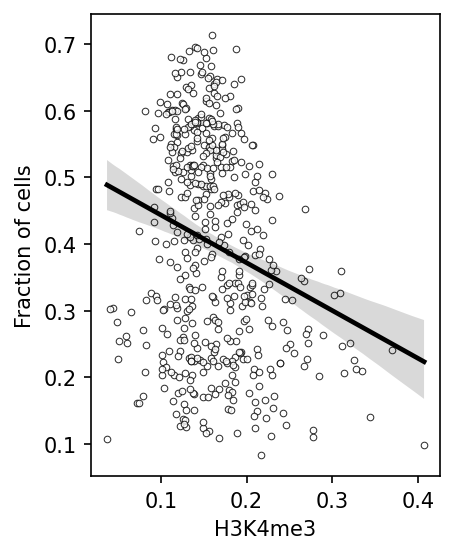

In [45]:
states = [1,2,3]

X = (np.tile(lads.loc[(lads[0] != '8'),'H3K4me3'], len(states)))
states_sum = np.array([(Zgroups_lads[g][:,(lads[0] != '8')] == state).sum(0) for state in states])
total_sum = (Zgroups_lads[g][:,(lads[0] != '8')] > 0).sum(0)
y = np.hstack((states_sum / total_sum))
hue = np.repeat(['DamID','ChIC','Both'],(lads[0] != '8').sum())

idx = (hue == 'Both') #& (X > -.5)
xhat, yhat, yhat_sem = sccu.RNR(X[idx], y[idx], _RADIUS=.05, step=.01)

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sns.regplot(x=X[idx], 
            y=y[idx],
            order=1,
            scatter_kws={'s':10,'color':'white','edgecolor':'k','lw':.5},
            line_kws={'color':'k'}
)
# ax.plot(xhat, yhat, color='white', lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# ax.fill_between(xhat, yhat -yhat_sem, yhat + yhat_sem, color='white', alpha=.25, 
#                 path_effects=[pe.Stroke(linewidth=.5, foreground='k'), pe.Normal()])

#ax.legend(prop={'size':6})
ax.set_xlabel('H3K4me3')
ax.set_ylabel('Fraction of cells')

Text(0, 0.5, 'Fraction of cells')

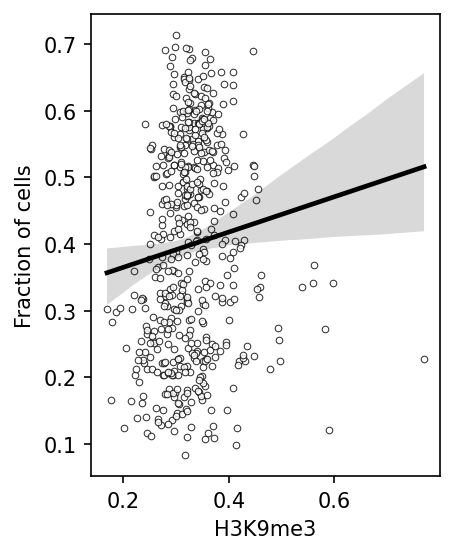

In [46]:
states = [1,2,3]

X = (np.tile(lads.loc[(lads[0] != '8'),'H3K9me3'], len(states)))
states_sum = np.array([(Zgroups_lads[g][:,(lads[0] != '8')] == state).sum(0) for state in states])
total_sum = (Zgroups_lads[g][:,(lads[0] != '8')] > 0).sum(0)
y = np.hstack((states_sum / total_sum))
hue = np.repeat(['DamID','ChIC','Both'],(lads[0] != '8').sum())

idx = (hue == 'Both') #& (X > -.5)
xhat, yhat, yhat_sem = sccu.RNR(X[idx], y[idx], _RADIUS=.05, step=.01)

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sns.regplot(x=X[idx], 
            y=y[idx],
            order=1,
            scatter_kws={'s':10,'color':'white','edgecolor':'k','lw':.5},
            line_kws={'color':'k'}
)
# ax.plot(xhat, yhat, color='white', lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# ax.fill_between(xhat, yhat -yhat_sem, yhat + yhat_sem, color='white', alpha=.25, 
#                 path_effects=[pe.Stroke(linewidth=.5, foreground='k'), pe.Normal()])

#ax.legend(prop={'size':6})
ax.set_xlabel('H3K9me3')
ax.set_ylabel('Fraction of cells')

Text(0, 0.5, 'Fraction of cells')

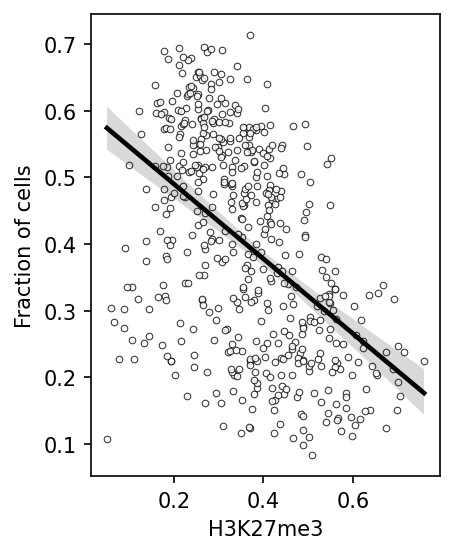

In [47]:
states = [1,2,3]

X = (np.tile(lads.loc[(lads[0] != '8'),'H3K27me3'], len(states)))
states_sum = np.array([(Zgroups_lads[g][:,(lads[0] != '8')] == state).sum(0) for state in states])
total_sum = (Zgroups_lads[g][:,(lads[0] != '8')] > 0).sum(0)
y = np.hstack((states_sum / total_sum))
hue = np.repeat(['DamID','ChIC','Both'],(lads[0] != '8').sum())

idx = (hue == 'Both') #& (X > -.5)
xhat, yhat, yhat_sem = sccu.RNR(X[idx], y[idx], _RADIUS=.05, step=.01)

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sns.regplot(x=X[idx], 
            y=y[idx],
            order=1,
            scatter_kws={'s':10,'color':'white','edgecolor':'k','lw':.5},
            line_kws={'color':'k'}
)
# ax.plot(xhat, yhat, color='white', lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# ax.fill_between(xhat, yhat -yhat_sem, yhat + yhat_sem, color='white', alpha=.25, 
#                 path_effects=[pe.Stroke(linewidth=.5, foreground='k'), pe.Normal()])

#ax.legend(prop={'size':6})
ax.set_xlabel('H3K27me3')
ax.set_ylabel('Fraction of cells')

In [49]:
repeats = pd.read_csv('/Users/prullens/metadata/repeatmasker.hg19.txt.gz', sep='\t', header=None)
repeats[0] = repeats[0].str.strip('chr')
repeats = repeats[repeats[0].isin(CHROMS)]

sine_density = {c: np.zeros((chromsizes[c] // BINSIZE)+1) for c in CHROMS}
for c,s,e in repeats.loc[repeats[3].str.contains('Alu'),[0,1,2]].values:
    s //= BINSIZE
    e //= BINSIZE
    sine_density[c][s:e+1] += 1

line_density = {c: np.zeros((chromsizes[c] // BINSIZE)+1) for c in CHROMS}
for c,s,e in repeats.loc[repeats[3].str.contains('L1'),[0,1,2]].values:
    s //= BINSIZE
    e //= BINSIZE
    line_density[c][s:e+1] += 1
    
lads['L1'] = [line_density[c][s//BINSIZE:e//BINSIZE].mean() for c,s,e in lads[[0,1,2]].values]
lads['Alu'] = [sine_density[c][s//BINSIZE:e//BINSIZE].mean() for c,s,e in lads[[0,1,2]].values]

/opt/miniconda3/envs/scanalysis/lib/python3.8/site-packages/sklearn/neighbors/_regression.py:500: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/prullens/Documents/GitHub/scChromTools/local/scChromUtils.py:9: RuntimeWarning: invalid value encountered in scalar divide
  wmean = (w * y).sum() / wsum
/Users/prullens/Documents/GitHub/scChromTools/local/scChromUtils.py:10: RuntimeWarning: invalid value encountered in scalar divide
  wstddev = np.sqrt((w * (y - wmean) ** 2).sum() / wsum)


Text(0, 0.5, 'Fraction of cells')

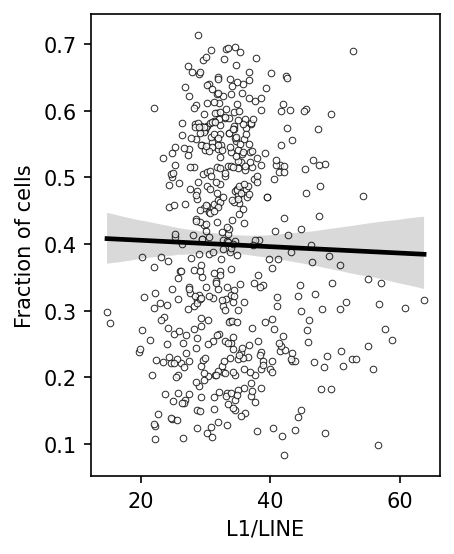

In [51]:
states = [1,2,3]

X = (np.tile(lads.loc[(lads[0] != '8'),'L1'], len(states)))
states_sum = np.array([(Zgroups_lads[g][:,(lads[0] != '8')] == state).sum(0) for state in states])
total_sum = (Zgroups_lads[g][:,(lads[0] != '8')] > 0).sum(0)
y = np.hstack((states_sum / total_sum))
hue = np.repeat(['DamID','ChIC','Both'],(lads[0] != '8').sum())

idx = (hue == 'Both') #& (X > -.5)
xhat, yhat, yhat_sem = sccu.RNR(X[idx], y[idx], _RADIUS=.05, step=.01)

f, ax = plt.subplots(figsize=(3,4), dpi=150)

sns.regplot(x=X[idx], 
            y=y[idx],
            order=1,
            scatter_kws={'s':10,'color':'white','edgecolor':'k','lw':.5},
            line_kws={'color':'k'}
)
# ax.plot(xhat, yhat, color='white', lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# ax.fill_between(xhat, yhat -yhat_sem, yhat + yhat_sem, color='white', alpha=.25, 
#                 path_effects=[pe.Stroke(linewidth=.5, foreground='k'), pe.Normal()])

#ax.legend(prop={'size':6})
ax.set_xlabel('L1/LINE')
ax.set_ylabel('Fraction of cells')